In [1]:
import networkx as nx
import numpy as np
from scipy import ndimage as ndi

def add_edge_filter(values, graph):
    center = values[len(values) // 2]
    for neighbor in values:
        if neighbor != center and not graph.has_edge(center, neighbor):
            graph.add_edge(center, neighbor)
    return 0.0


def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    _ = ndi.generic_filter(labels, add_edge_filter, footprint=footprint,
                           mode='nearest', extra_arguments=(g,))
    return g

In [2]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../style/elegant.mplstyle')

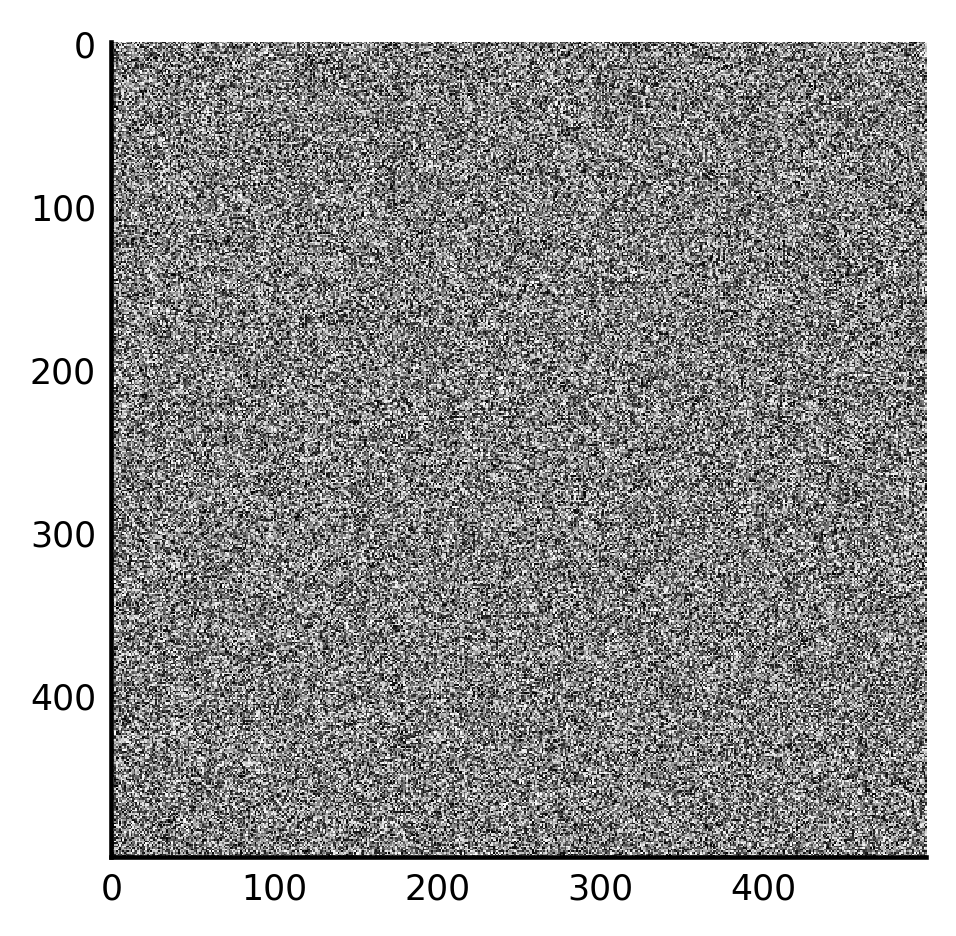

In [3]:
import numpy as np
random_image = np.random.rand(500, 500)
plt.imshow(random_image);

Type: <class 'numpy.ndarray'> Shape: (303, 384) Data type: uint8


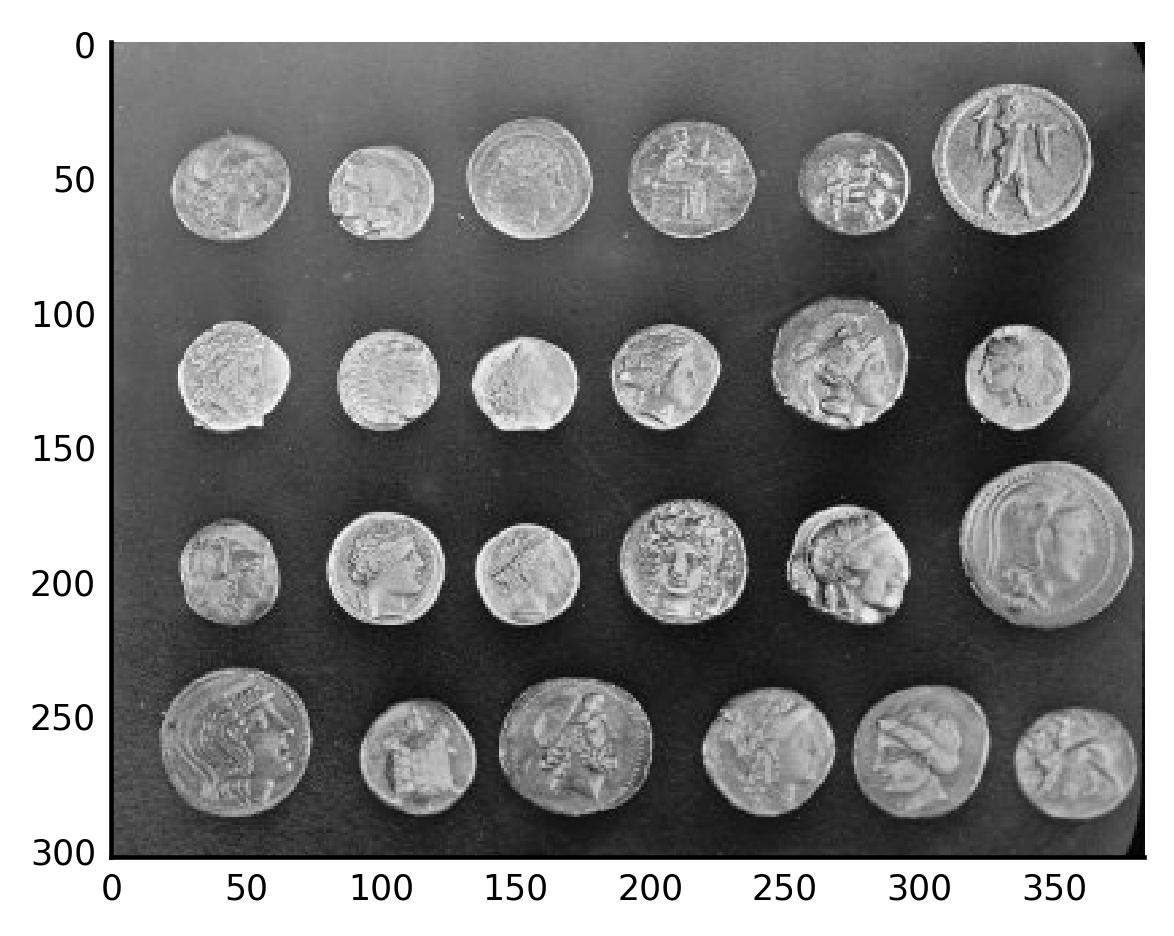

In [4]:
from skimage import io
url_coins = ('https://raw.githubusercontent.com/scikit-image/scikit-image/'
             'v0.10.1/skimage/data/coins.png')
coins = io.imread(url_coins)
print("Type:", type(coins), "Shape:", coins.shape, "Data type:", coins.dtype)
plt.imshow(coins);

Type: <class 'numpy.ndarray'> Shape: (512, 512, 3) Data type: uint8


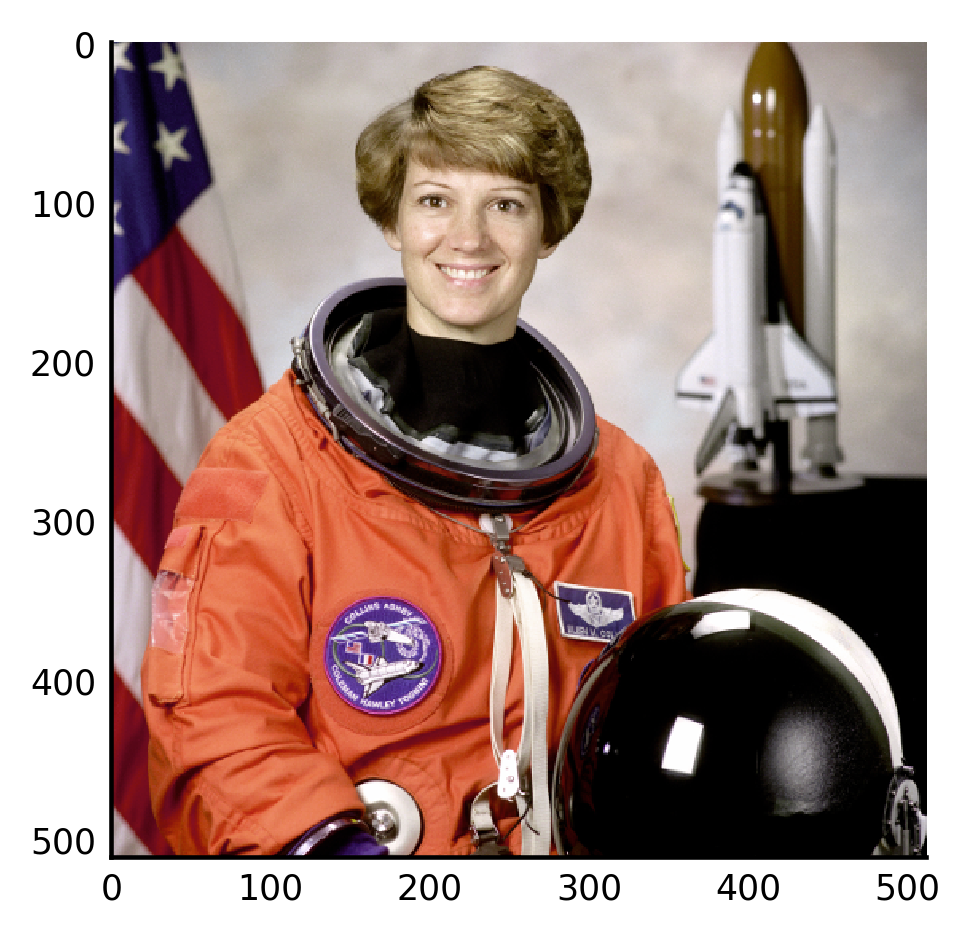

In [5]:
url_astronaut = ('https://raw.githubusercontent.com/scikit-image/scikit-image/'
                 'master/skimage/data/astronaut.png')
astro = io.imread(url_astronaut)
print("Type:", type(astro), "Shape:", astro.shape, "Data type:", astro.dtype)
plt.imshow(astro);

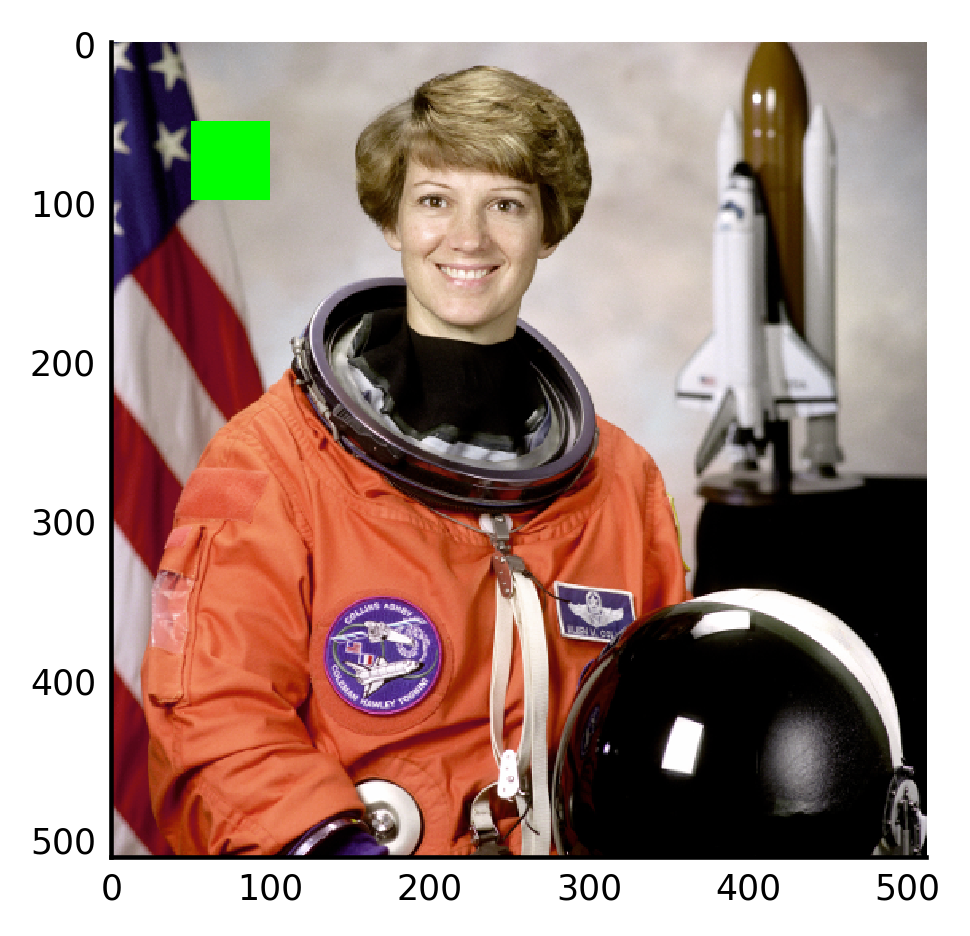

In [6]:
astro_sq = np.copy(astro)
astro_sq[50:100, 50:100] = [0, 255, 0]  # red, green, blue
plt.imshow(astro_sq);

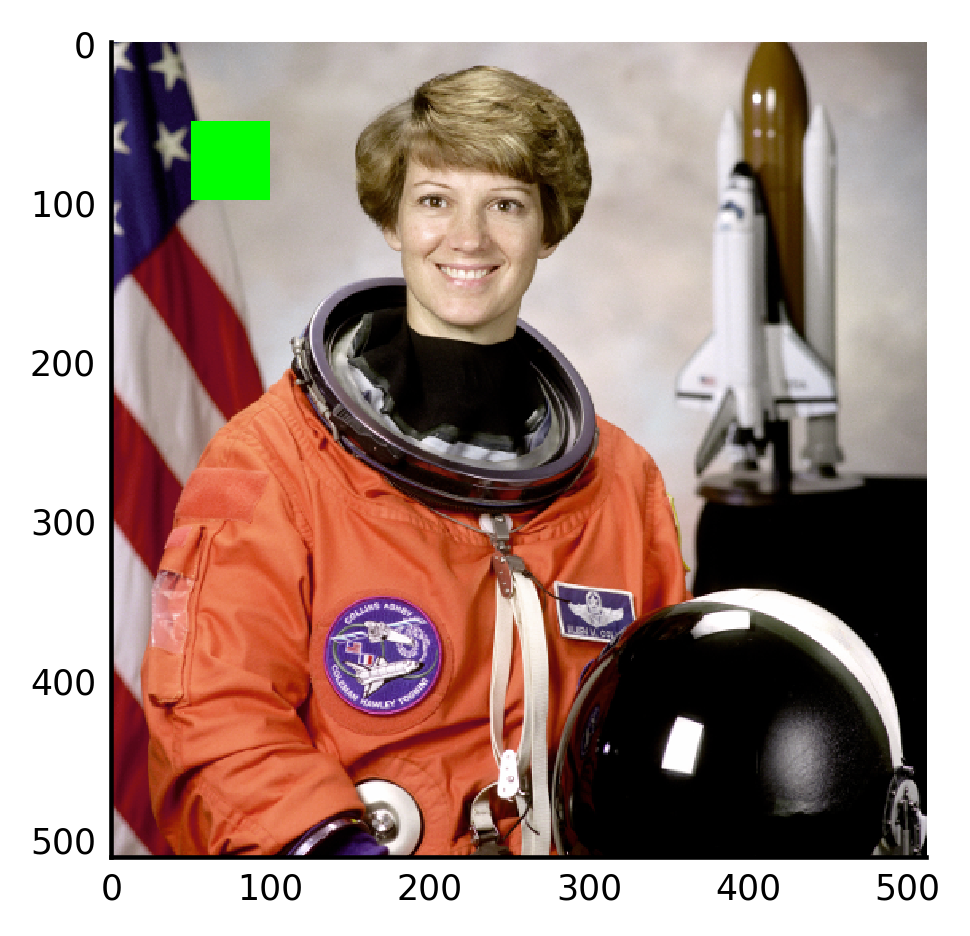

In [7]:
astro_sq = np.copy(astro)
sq_mask = np.zeros(astro.shape[:2], bool)
sq_mask[50:100, 50:100] = True
astro_sq[sq_mask] = [0, 255, 0]
plt.imshow(astro_sq);

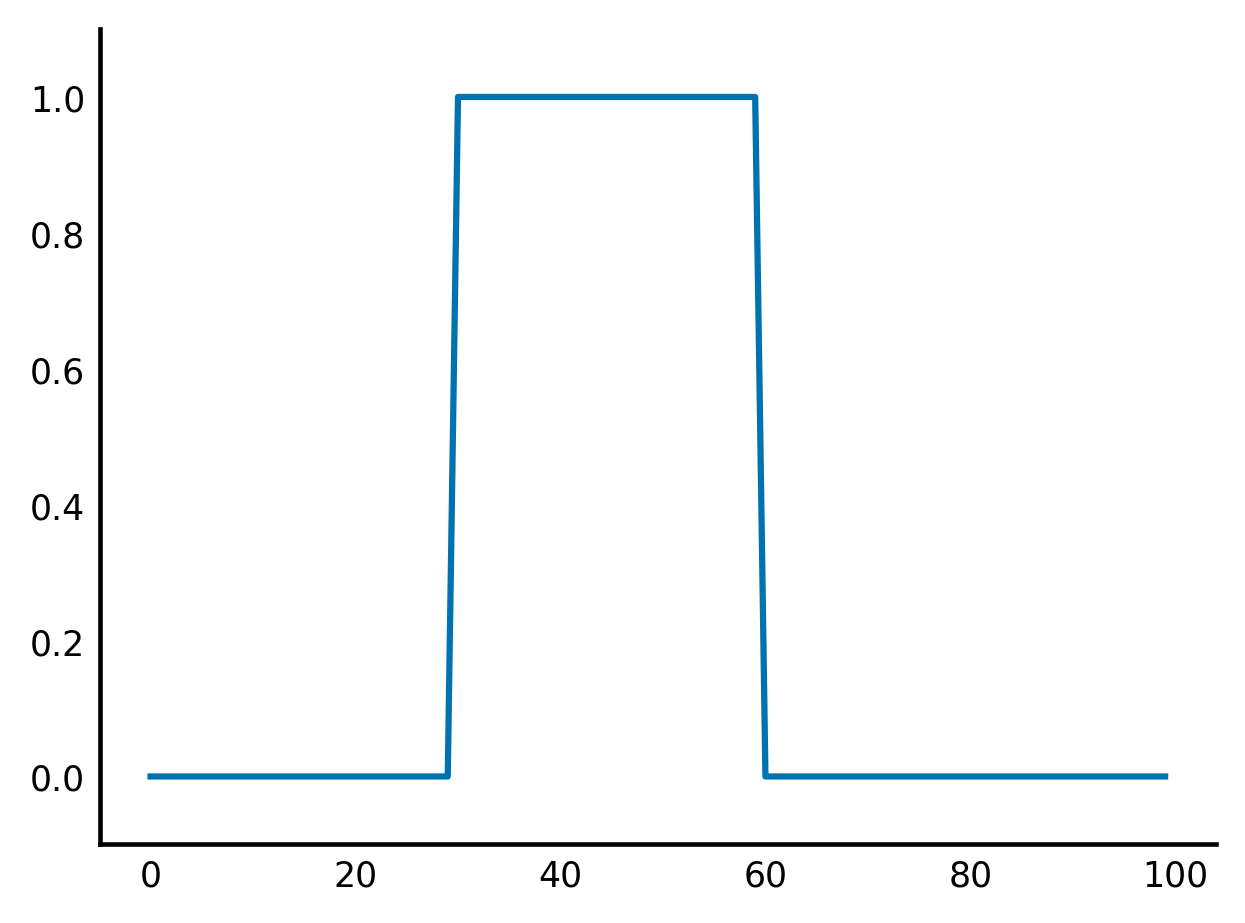

In [8]:
sig = np.zeros(100, np.float) #
sig[30:60] = 1  # signal = 1 during the period 30-60ms because light is observed
fig, ax = plt.subplots()
ax.plot(sig);
ax.set_ylim(-0.1, 1.1);

Signal on at: 30 ms


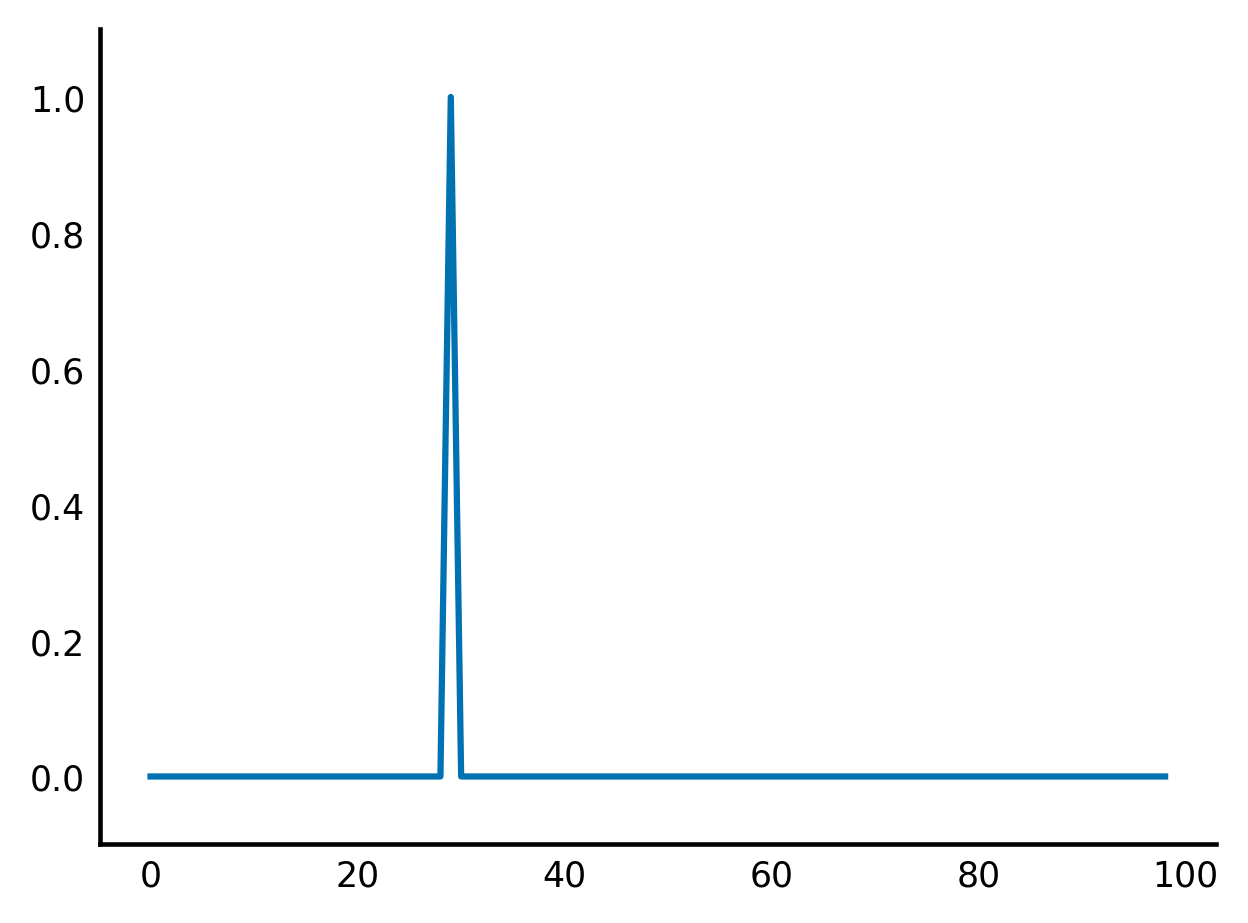

In [9]:
sigdelta = sig[1:]  # sigdelta[0] equals sig[1], and so on
sigdiff = sigdelta - sig[:-1]
sigon = np.clip(sigdiff, 0, np.inf)
fig, ax = plt.subplots()
ax.plot(sigon)
ax.set_ylim(-0.1, 1.1)
print('Signal on at:', 1 + np.flatnonzero(sigon)[0], 'ms')

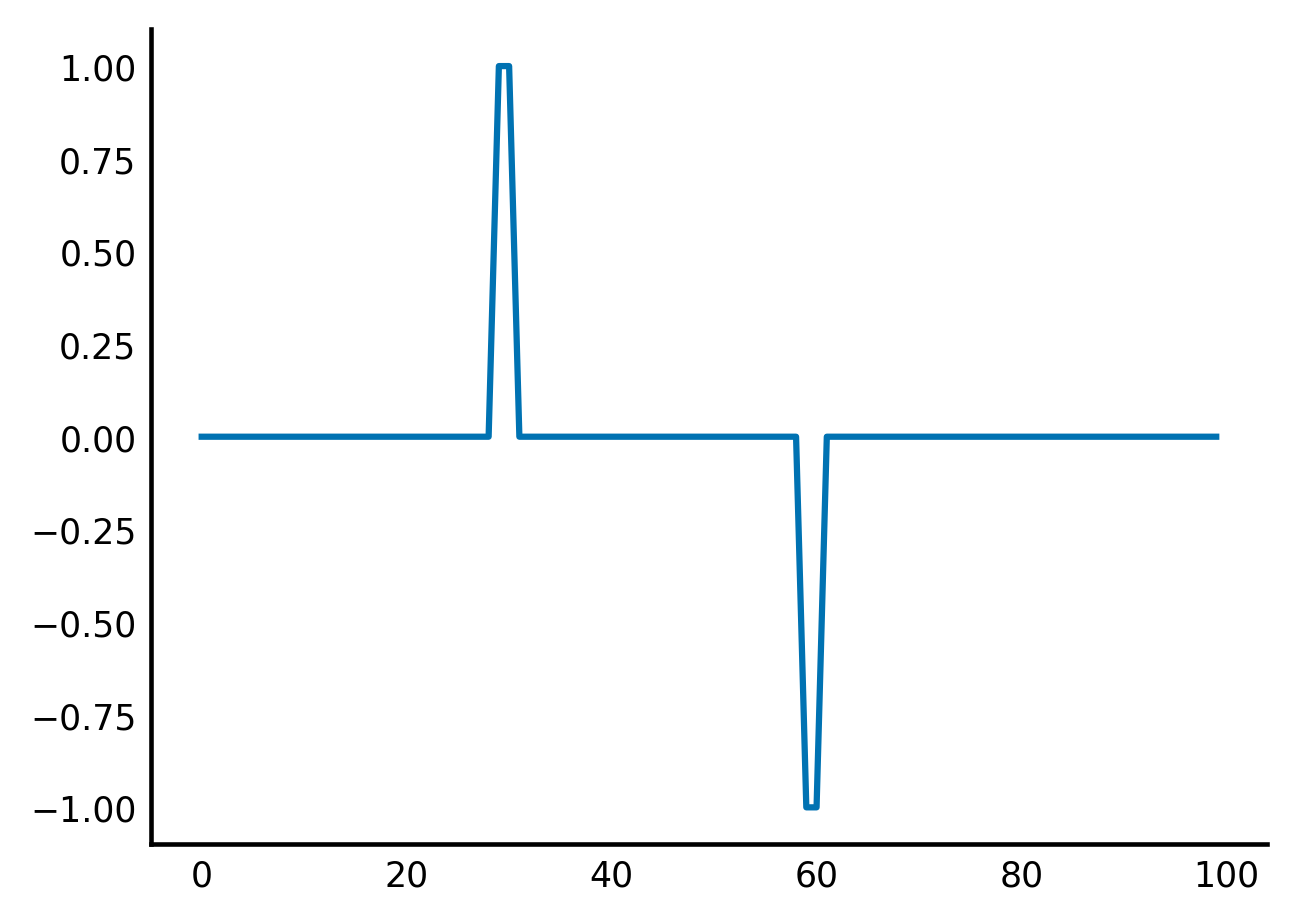

In [10]:
diff = np.array([1, 0, -1])
from scipy import ndimage as ndi
dsig = ndi.convolve(sig, diff)
plt.plot(dsig);

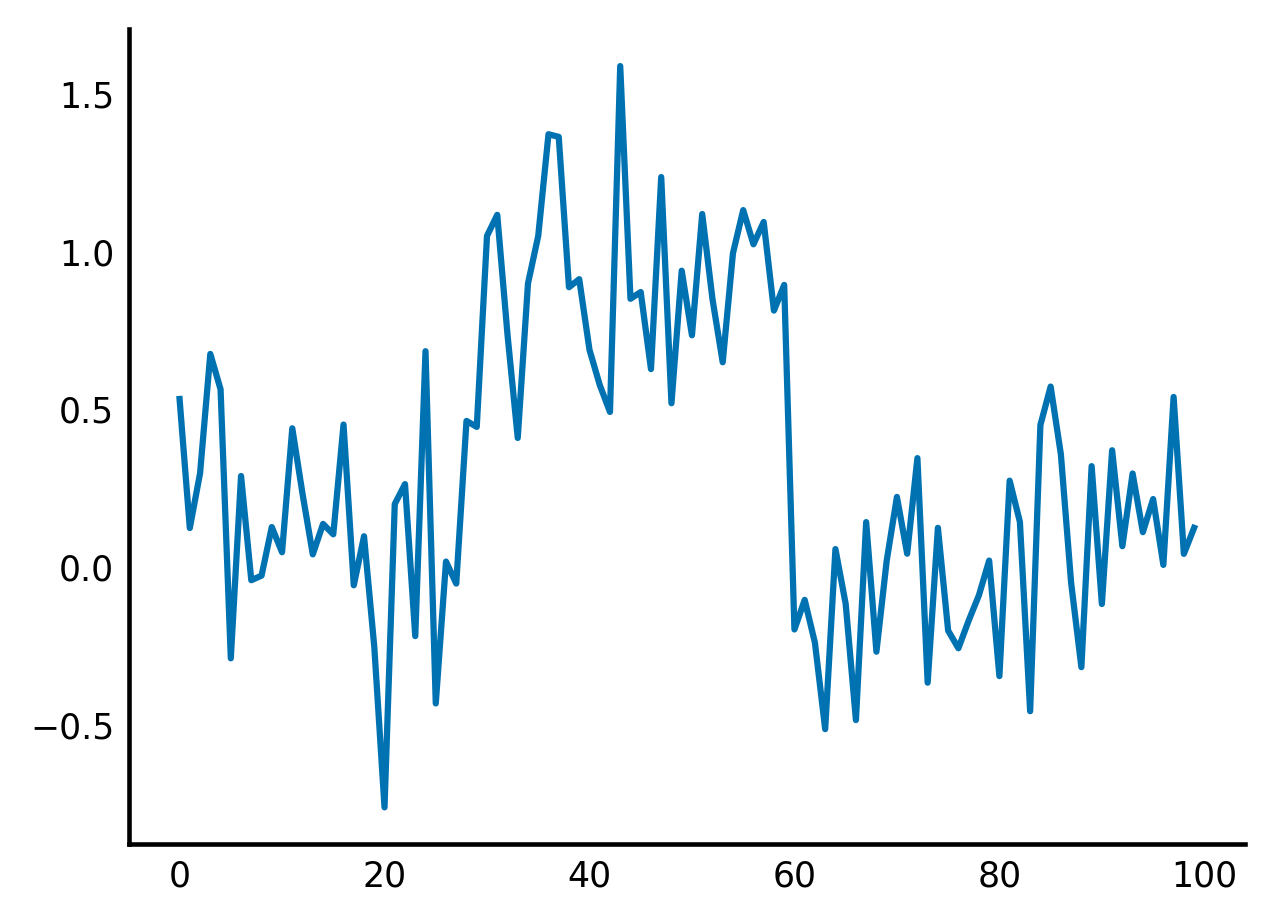

In [11]:
np.random.seed(0)
sig = sig + np.random.normal(0, 0.3, size=sig.shape)
plt.plot(sig);

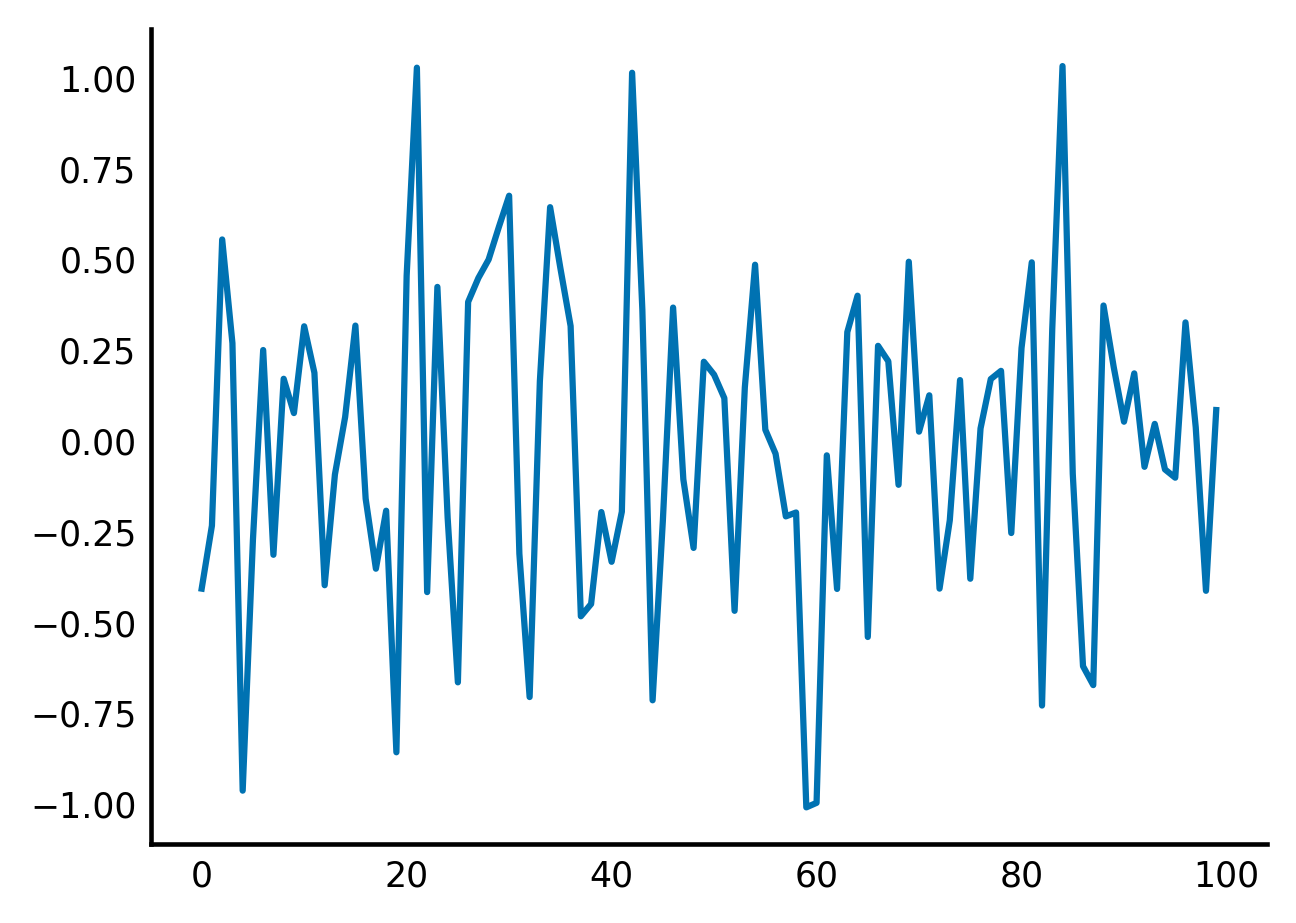

In [12]:
plt.plot(ndi.convolve(sig, diff));

In [13]:
def gaussian_kernel(size, sigma):
    """Make a 1D Gaussian kernel of the specified size and standard deviation.

    The size should be an odd number and at least ~6 times greater than sigma
    to ensure sufficient coverage.
    """
    positions = np.arange(size) - size // 2
    kernel_raw = np.exp(-positions**2 / (2 * sigma**2))
    kernel_normalized = kernel_raw / np.sum(kernel_raw)
    return kernel_normalized

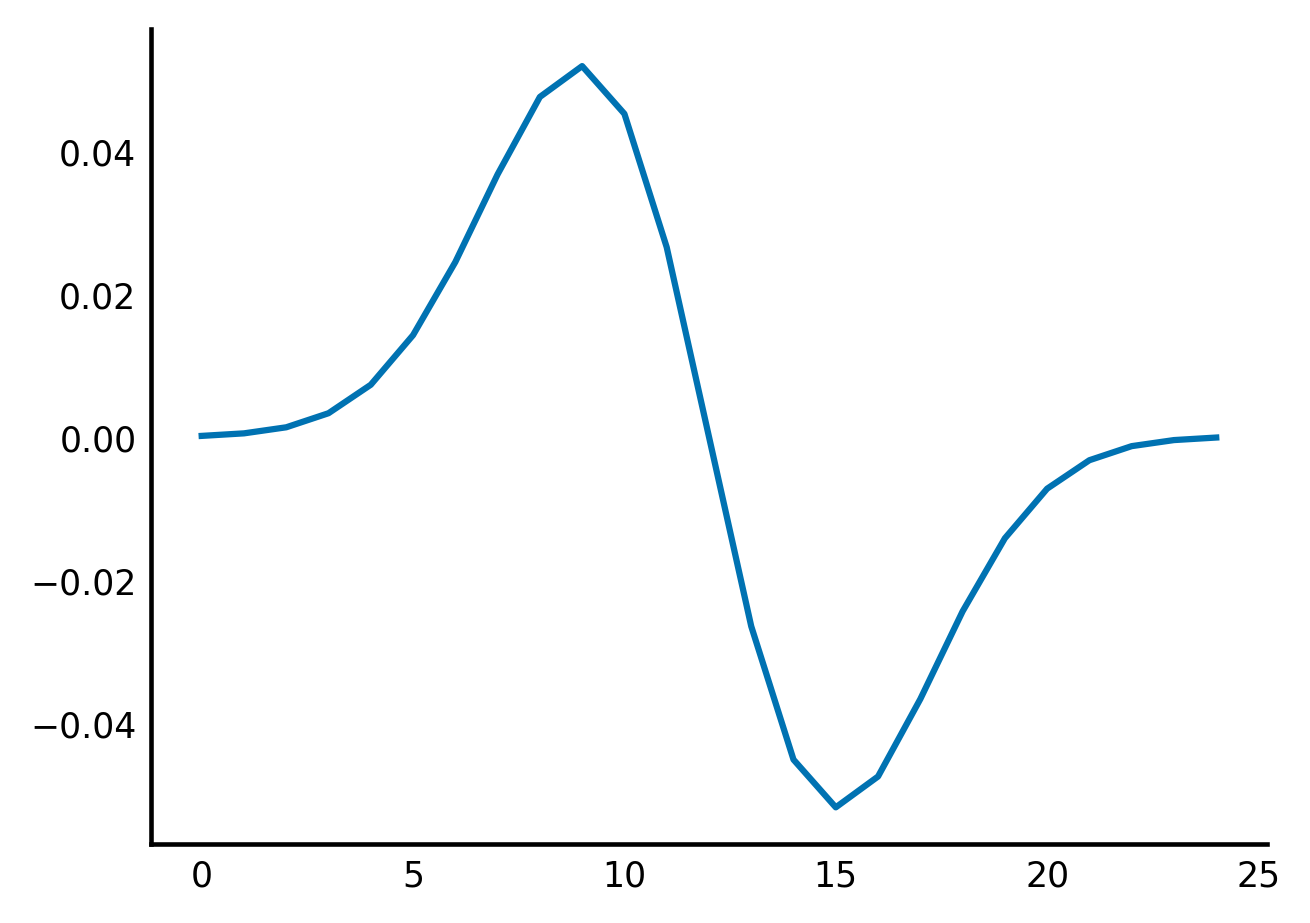

In [14]:
smooth_diff = ndi.convolve(gaussian_kernel(25, 3), diff)
plt.plot(smooth_diff);

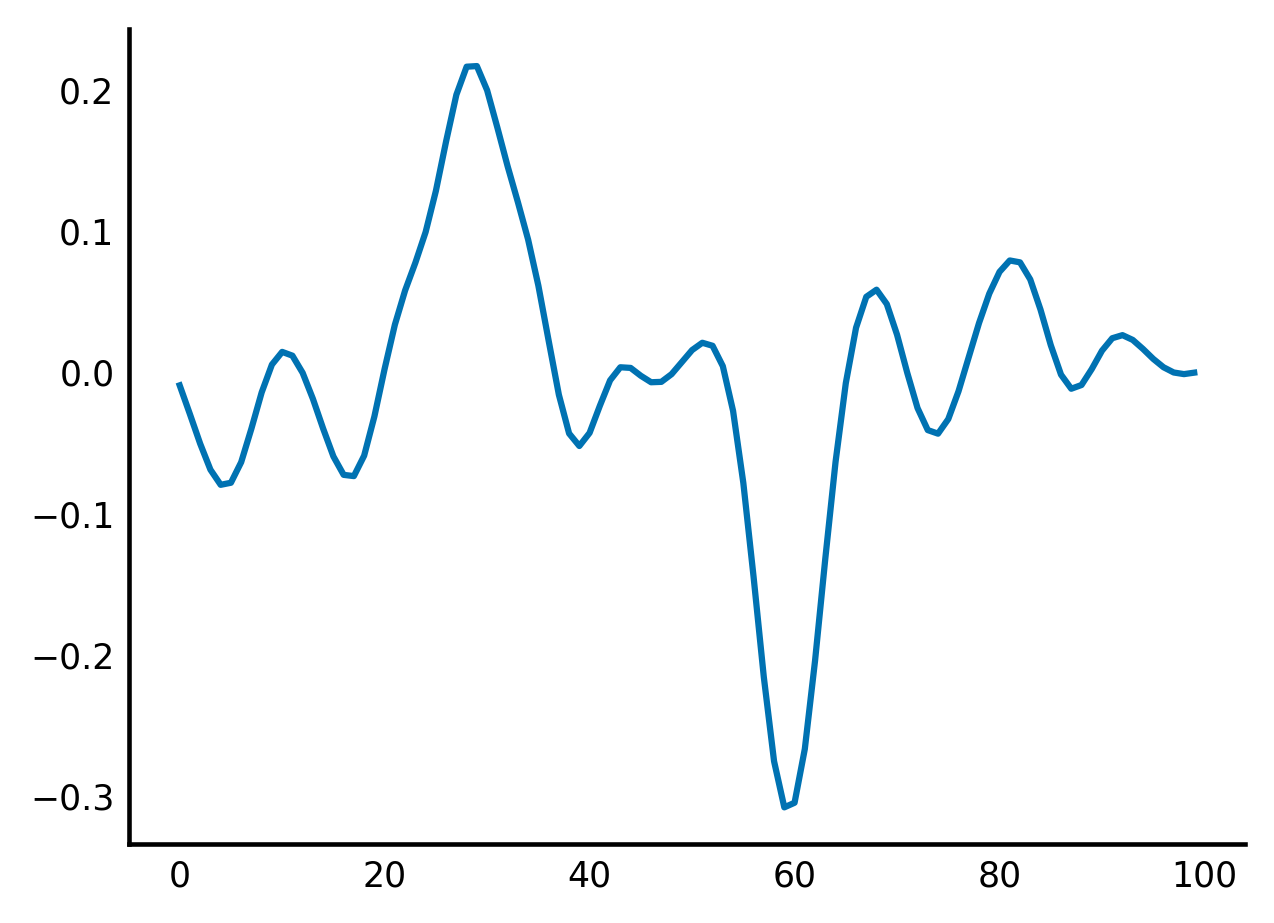

In [15]:
sdsig = ndi.convolve(sig, smooth_diff)
plt.plot(sdsig);

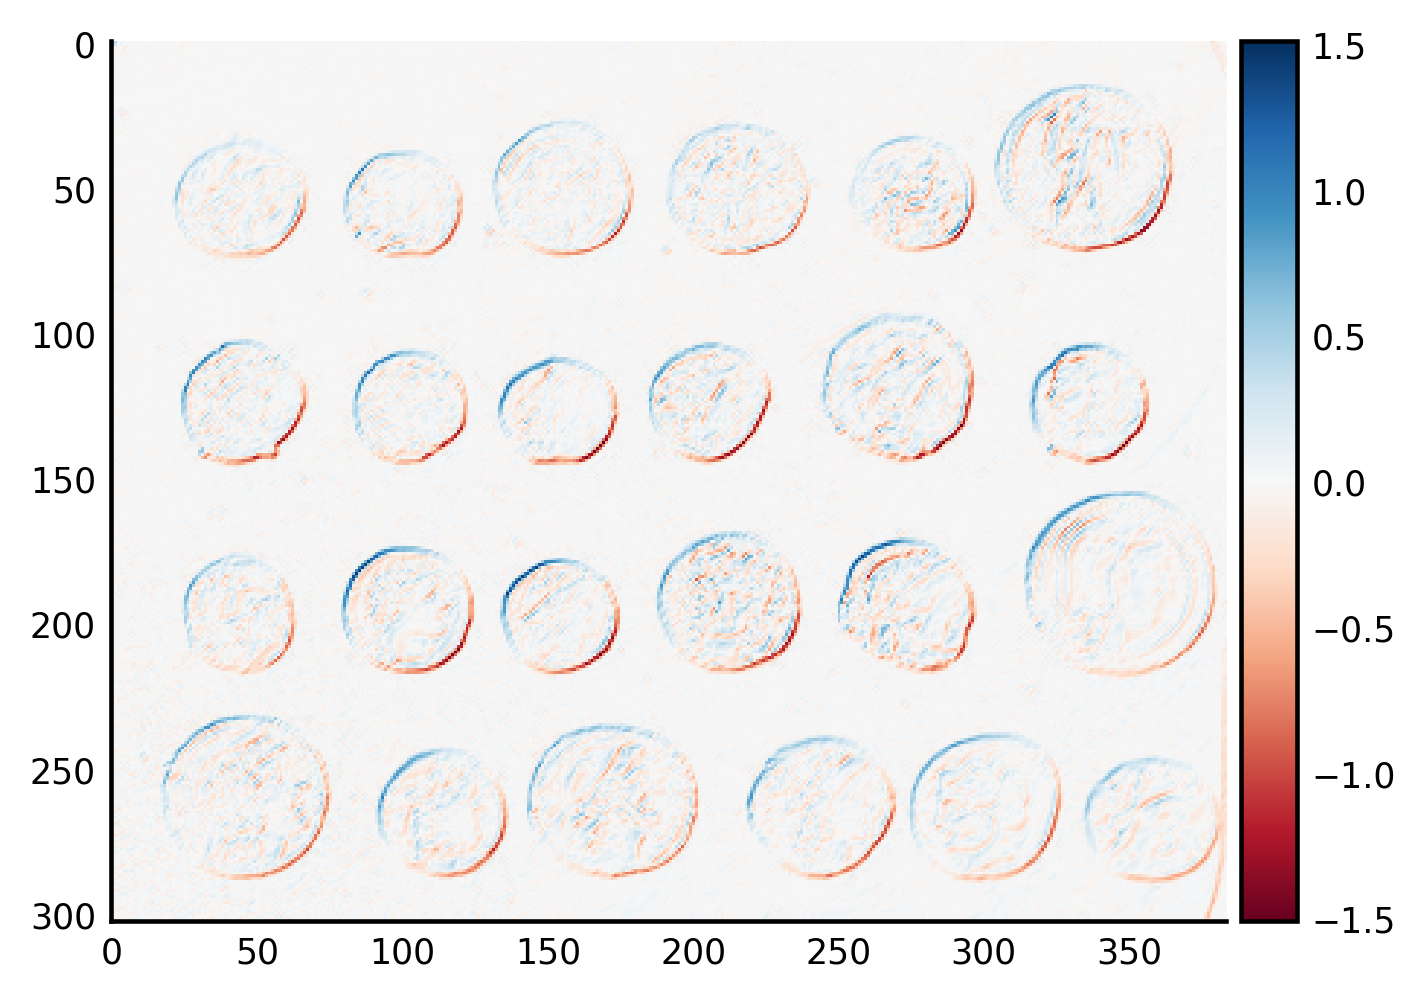

In [16]:
coins = coins.astype(float) / 255  # prevents overflow errors
diff2d = np.array([[0, 1, 0], [1, 0, -1], [0, -1, 0]])
coins_edges = ndi.convolve(coins, diff2d)
io.imshow(coins_edges);

In [17]:
# column vector (vertical) to find horizontal edges
hdiff = np.array([[1], [0], [-1]])

In [18]:
hsobel = np.array([[ 1,  2,  1],
                   [ 0,  0,  0],
                   [-1, -2, -1]])

In [19]:
vsobel = hsobel.T

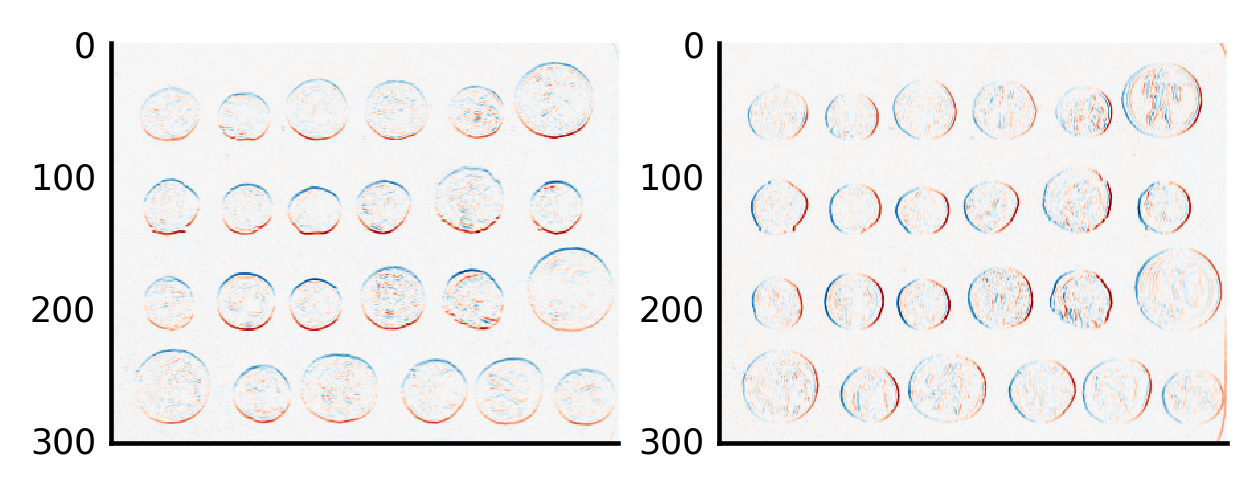

In [20]:
# Some custom x-axis labeling to make our plots easier to read
def reduce_xaxis_labels(ax, factor):
    """Show only every ith label to prevent crowding on x-axis,
        e.g., factor = 2 would plot every second x-axis label,
        starting at the first.

    Parameters
    ----------
    ax : matplotlib plot axis to be adjusted
    factor : int, factor to reduce the number of x-axis labels by
    """
    plt.setp(ax.xaxis.get_ticklabels(), visible=False)
    for label in ax.xaxis.get_ticklabels()[::factor]:
        label.set_visible(True)


coins_h = ndi.convolve(coins, hsobel)
coins_v = ndi.convolve(coins, vsobel)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(coins_h, cmap=plt.cm.RdBu)
axes[1].imshow(coins_v, cmap=plt.cm.RdBu)
for ax in axes:
    reduce_xaxis_labels(ax, 2)


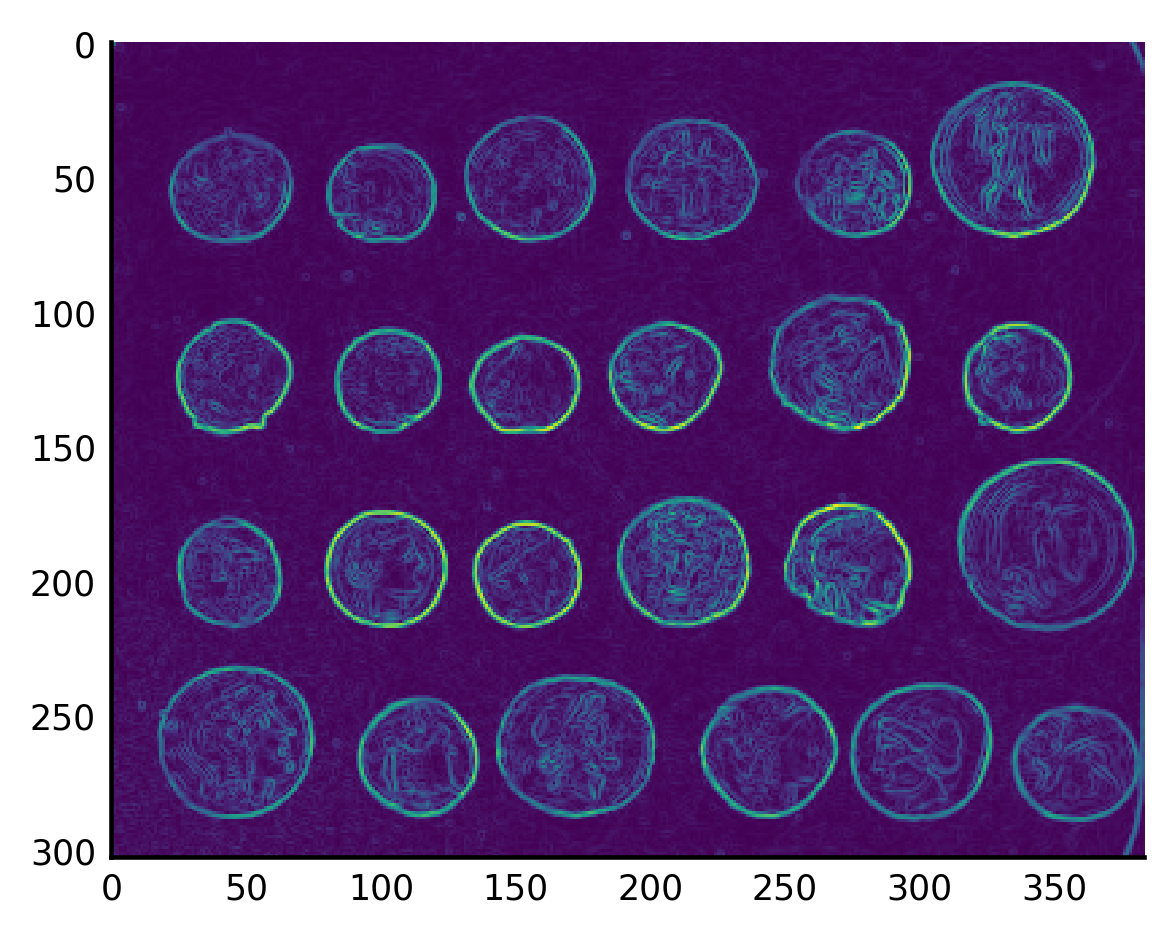

In [21]:
coins_sobel = np.sqrt(coins_h**2 + coins_v**2)
plt.imshow(coins_sobel, cmap='viridis');

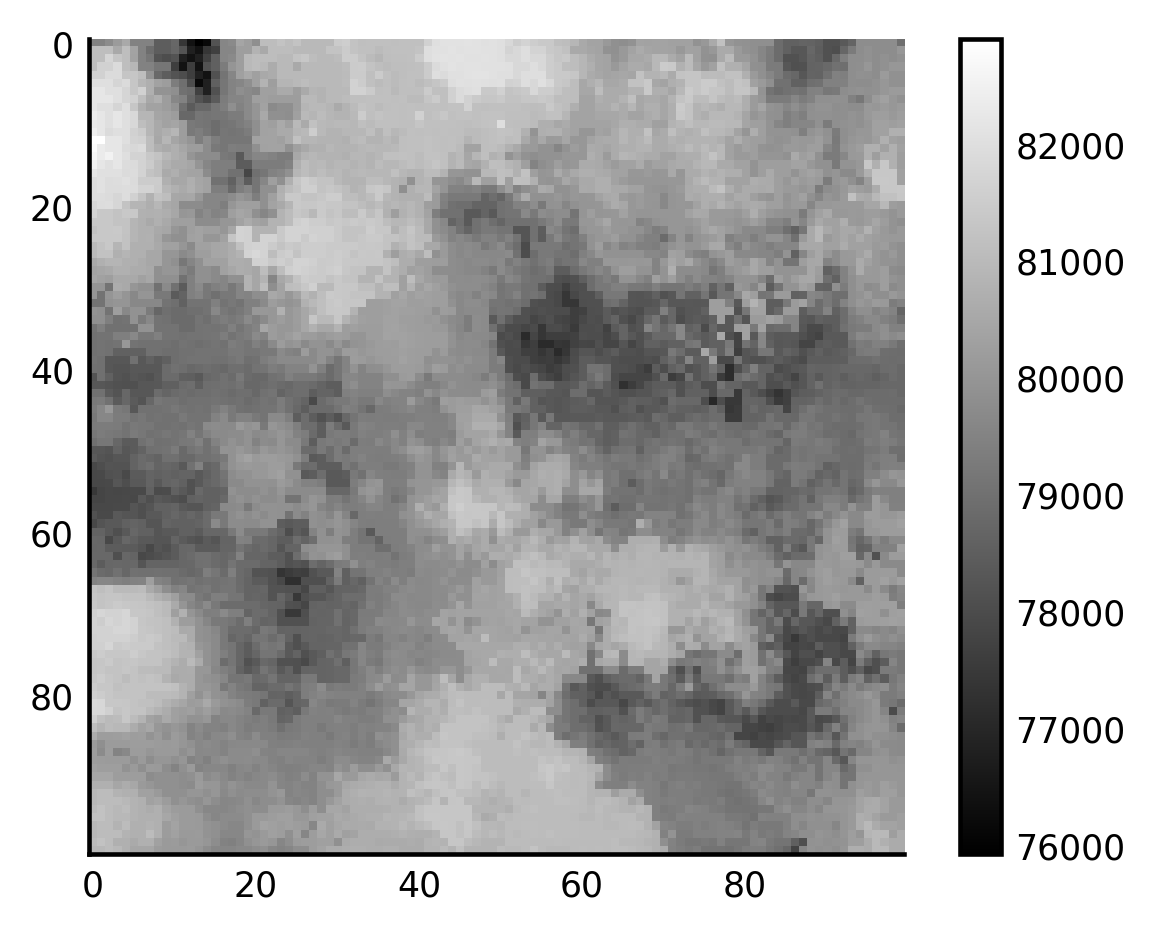

In [22]:
from skimage import morphology
def tax(prices):
    return 10000 + 0.05 * np.percentile(prices, 90)
house_price_map = (0.5 + np.random.rand(100, 100)) * 1e6
footprint = morphology.disk(radius=10)
tax_rate_map = ndi.generic_filter(house_price_map, tax, footprint=footprint)
plt.imshow(tax_rate_map)
plt.colorbar();

In [27]:
import pandas as pd
connectome_url = 'http://www.wormatlas.org/images/NeuronConnect.xls'
conn = pd.read_excel(connectome_url)

In [28]:
conn_edges = [(n1, n2, {'weight': s})
              for n1, n2, t, s in conn.itertuples(index=False, name=None)
              if t.startswith('S')]

In [72]:
import networkx as nx
wormbrain = nx.DiGraph()
wormbrain.add_edges_from(conn_edges)

In [73]:
centrality = nx.betweenness_centrality(wormbrain)

In [74]:
central = sorted(centrality, key=centrality.get, reverse=True)
print(central[:5])

['AVAR', 'AVAL', 'PVCR', 'PVT', 'PVCL']


In [75]:
sccs = (wormbrain.subgraph(c) for c in nx.strongly_connected_components(wormbrain))
giantscc = max(sccs, key=len)
print(f'The largest strongly connected component has '
      f'{giantscc.number_of_nodes()} nodes, out of '
      f'{wormbrain.number_of_nodes()} total.')

The largest strongly connected component has 237 nodes, out of 279 total.


In [77]:
in_degrees = list(dict(wormbrain.in_degree()).values())
in_deg_distrib = np.bincount(in_degrees)
avg_in_degree = np.mean(in_degrees)
cumfreq = np.cumsum(in_deg_distrib) / np.sum(in_deg_distrib)
survival = 1 - cumfreq

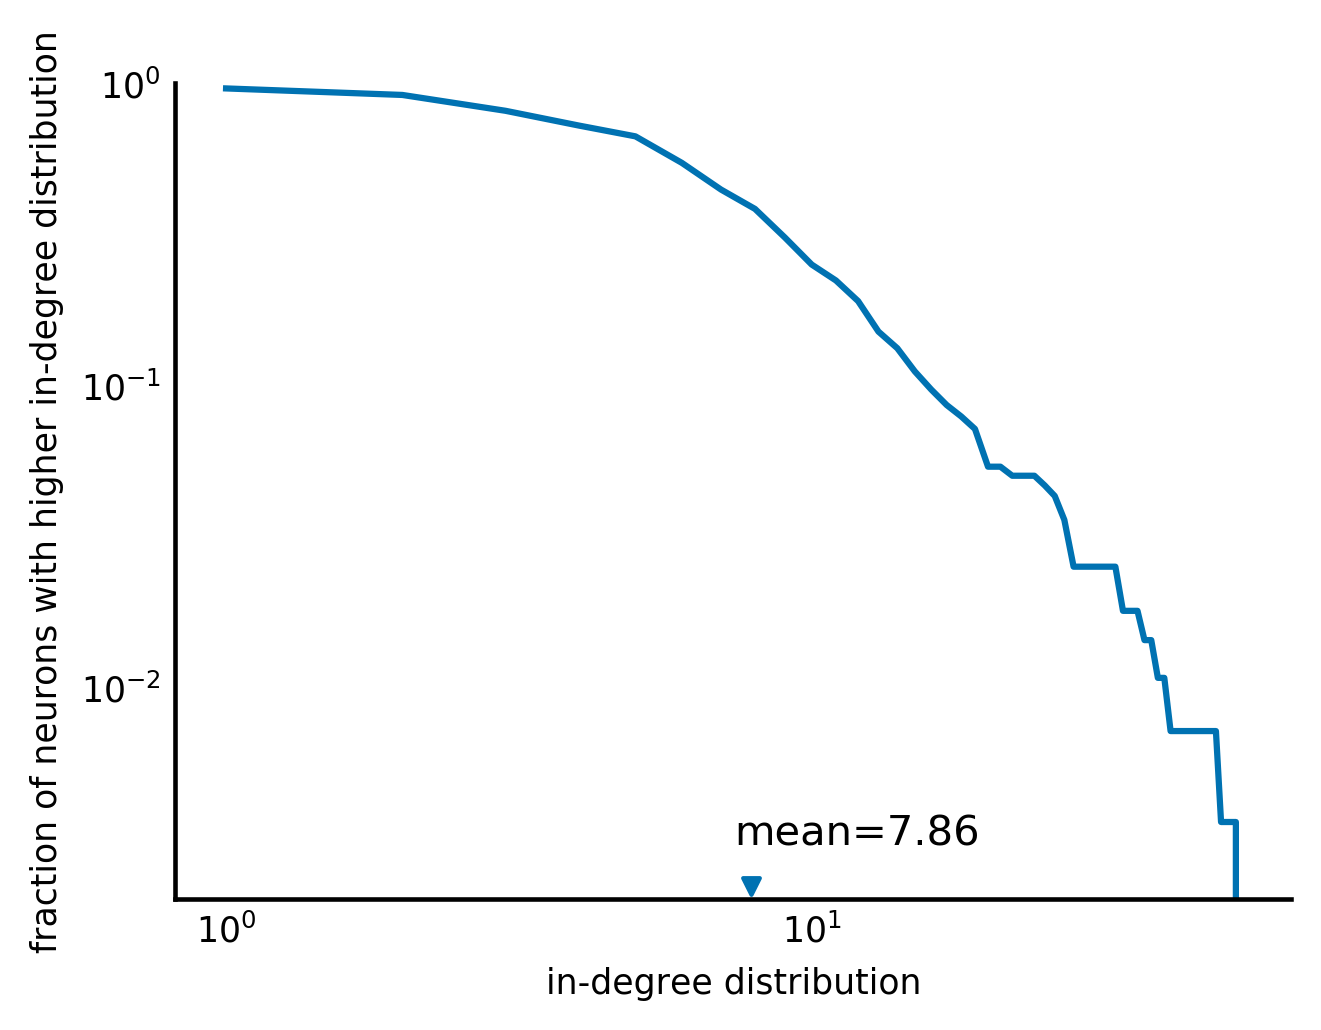

In [78]:
fig, ax = plt.subplots()
ax.loglog(np.arange(1, len(survival) + 1), survival)
ax.set_xlabel('in-degree distribution')
ax.set_ylabel('fraction of neurons with higher in-degree distribution')
ax.scatter(avg_in_degree, 0.0022, marker='v')
ax.text(avg_in_degree - 0.5, 0.003, 'mean=%.2f' % avg_in_degree)
ax.set_ylim(0.002, 1.0);

In [41]:
url = ('http://www.eecs.berkeley.edu/Research/Projects/CS/vision/'
       'bsds/BSDS300/html/images/plain/normal/color/108073.jpg')
tiger = io.imread(url)
from skimage import segmentation
seg = segmentation.slic(tiger, n_segments=30, compactness=40.0,
                        enforce_connectivity=True, sigma=3)

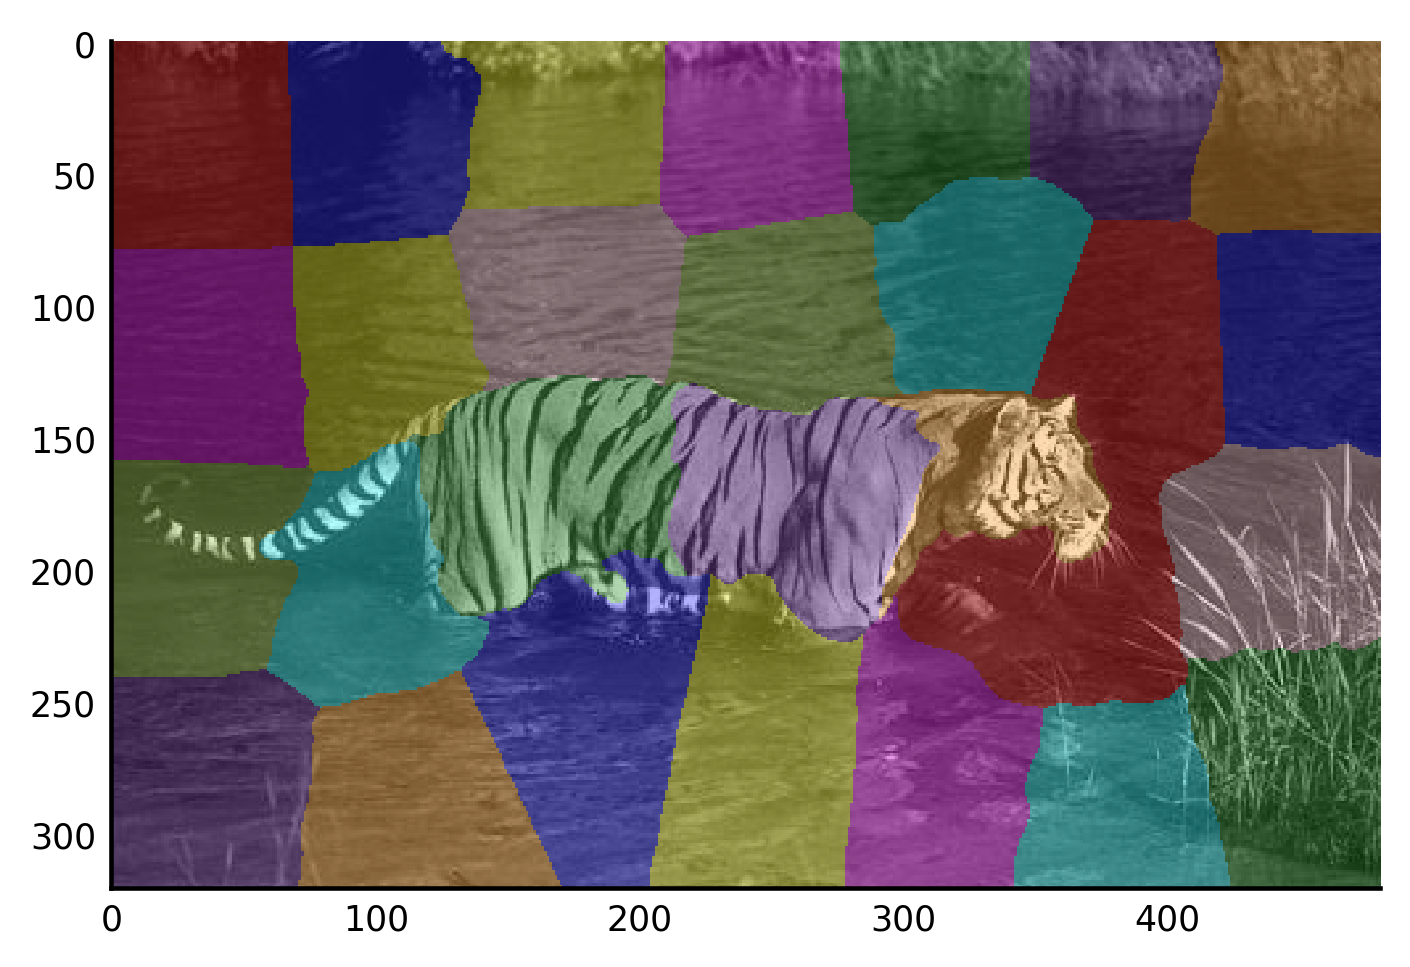

In [42]:
from skimage import color
io.imshow(color.label2rgb(seg, tiger));

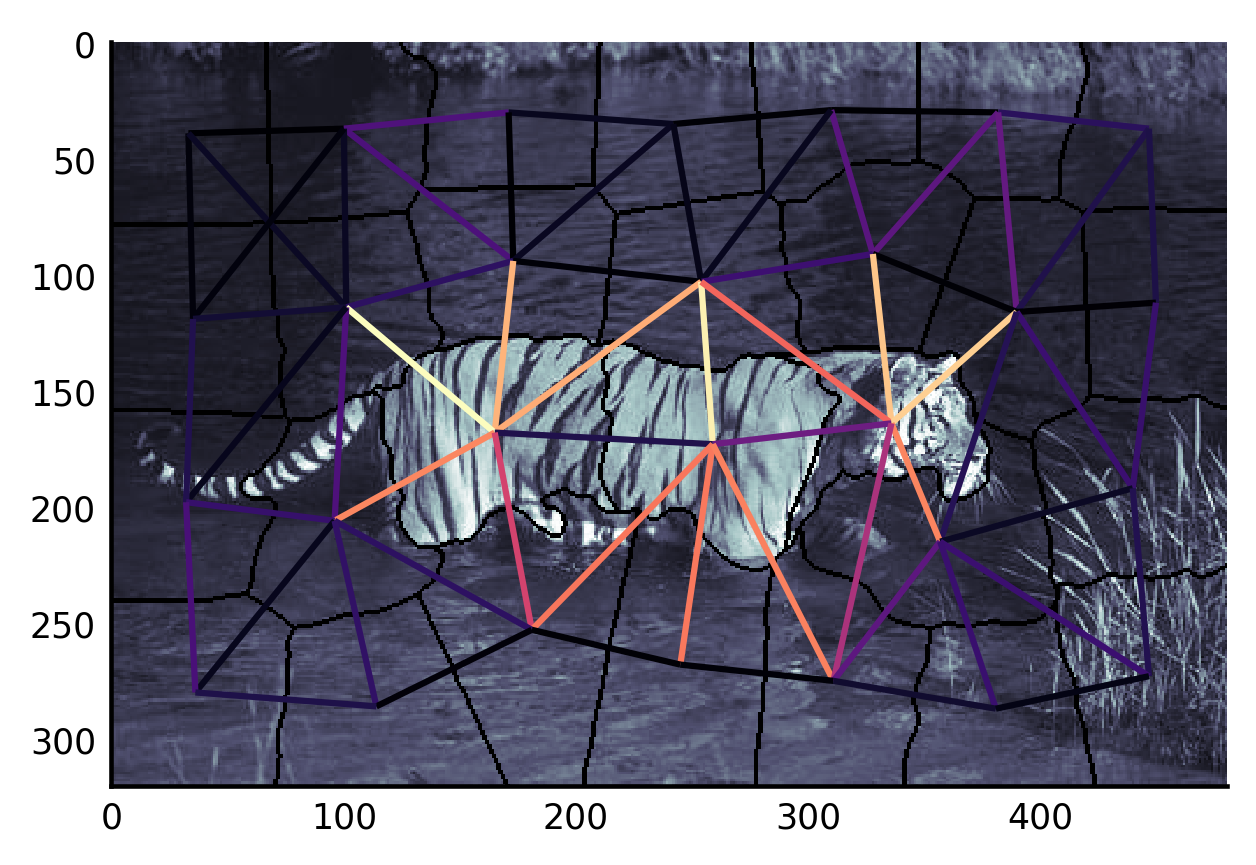

In [43]:
from skimage.future import graph

g = graph.rag_mean_color(tiger, seg)
graph.show_rag(seg, g, tiger);

In [45]:
import networkx as nx
def build_rag(labels, image):
    g = nx.Graph()
    nrows, ncols = labels.shape
    for row in range(nrows):
        for col in range(ncols):
            current_label = labels[row, col]
            if not current_label in g:
                g.add_node(current_label)
                g.node[current_label]['total color'] = np.zeros(3, dtype=np.float)
                g.node[current_label]['pixel count'] = 0
            if row < nrows - 1 and labels[row + 1, col] != current_label:
                g.add_edge(current_label, labels[row + 1, col])
            if col < ncols - 1 and labels[row, col + 1] != current_label:
                g.add_edge(current_label, labels[row, col + 1])
            g.node[current_label]['total color'] += image[row, col]
            g.node[current_label]['pixel count'] += 1
    return g

In [46]:
import networkx as nx
def build_rag_3d(labels, image):
    g = nx.Graph()
    nplns, nrows, ncols = labels.shape
    for pln in range(nplns):
        for row in range(nrows):
            for col in range(ncols):
                current_label = labels[pln, row, col]
                if not current_label in g:
                    g.add_node(current_label)
                    g.node[current_label]['total color'] = np.zeros(3, dtype=np.float)
                    g.node[current_label]['pixel count'] = 0
                if pln < nplns - 1 and labels[pln + 1, row, col] != current_label:
                    g.add_edge(current_label, labels[pln + 1, row, col])
                if row < nrows - 1 and labels[pln, row + 1, col] != current_label:
                    g.add_edge(current_label, labels[pln, row + 1, col])
                if col < ncols - 1 and labels[pln, row, col + 1] != current_label:
                    g.add_edge(current_label, labels[pln, row, col + 1])
                g.node[current_label]['total color'] += image[pln, row, col]
                g.node[current_label]['pixel count'] += 1
    return g

In [51]:
import networkx as nx
import numpy as np
from scipy import ndimage as nd

def add_edge_filter(values, graph):
    center = values[len(values) // 2]
    for neighbor in values:
        if neighbor != center and not graph.has_edge(center, neighbor):
            graph.add_edge(center, neighbor)
    # float return value is unused but needed by `generic_filter`
    return 0.0

def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    _ = ndi.generic_filter(labels, add_edge_filter, footprint=footprint,
                           mode='nearest', extra_arguments=(g,))
    for n in g:
        g.nodes[n]['total color'] = np.zeros(3, np.double)
        g.nodes[n]['pixel count'] = 0
    for index in np.ndindex(labels.shape):
        n = labels[index]
        g.nodes[n]['total color'] += image[index]
        g.nodes[n]['pixel count'] += 1
    return g

In [59]:
g = build_rag(seg, tiger)
for n in g:
    node = g.nodes[n]
    node['mean'] = node['total color'] / node['pixel count']
for u, v in g.edges():
    d = g.nodes[u]['mean'] - g.nodes[v]['mean']
    g[u][v]['weight'] = np.linalg.norm(d)

In [60]:
def threshold_graph(g, t):
    to_remove = [(u, v) for (u, v, d) in g.edges(data=True)
                 if d['weight'] > t]
    g.remove_edges_from(to_remove)
threshold_graph(g, 80)

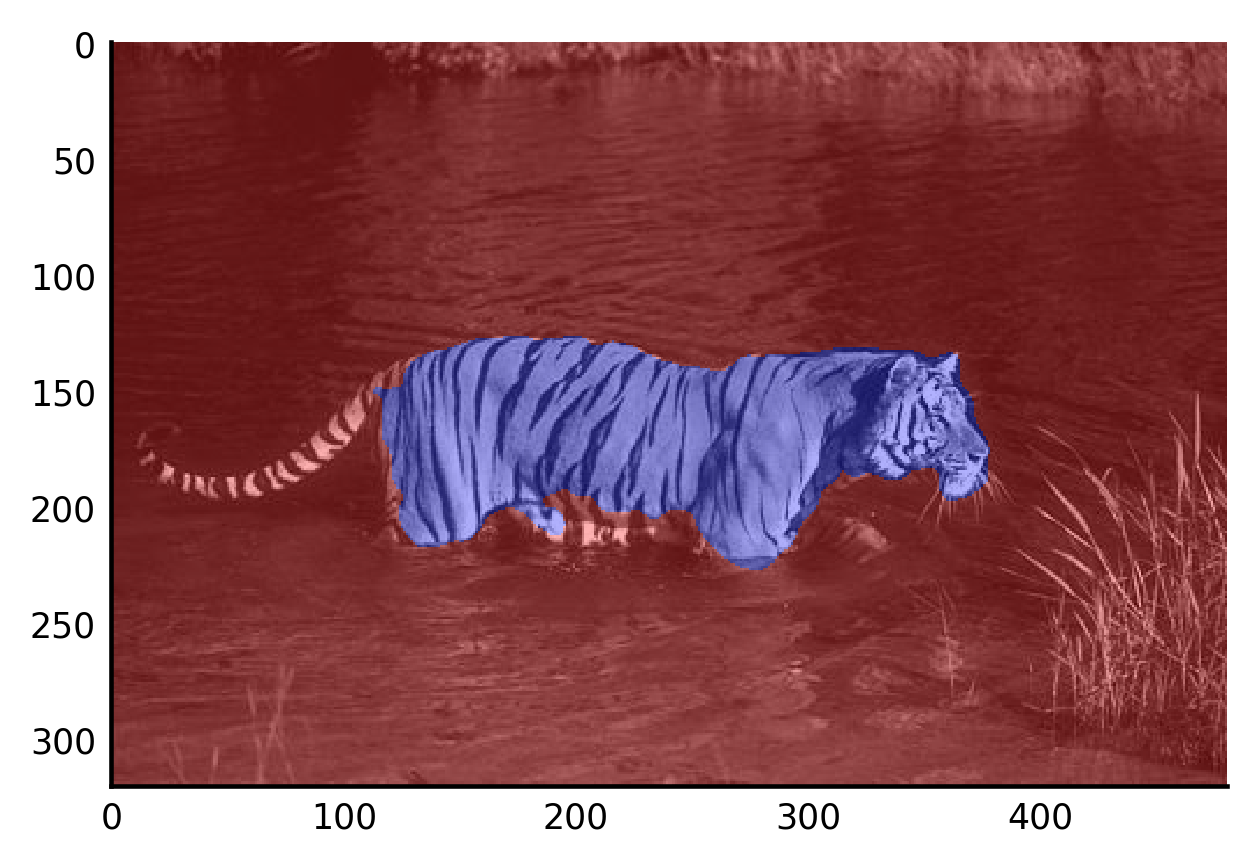

In [61]:
map_array = np.zeros(np.max(seg) + 1, int)
for i, segment in enumerate(nx.connected_components(g)):
    for initial in segment:
        map_array[int(initial)] = i
segmented = map_array[seg]
plt.imshow(color.label2rgb(segmented, tiger));